In [2]:
#need to pip install:
# pmdarima
# pytest
#
####################################################### IMPORTS ###################################################################
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import time
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
from arch import arch_model
import arch
import pmdarima

import warnings
warnings.filterwarnings("ignore")


In [3]:
####################################################### DATA EXTRACTION ###################################################################
path = 'C:\\Users\\elaar\\python_ATS\\Data_ATS.xlsm'

#Extract CDS prices
df = pd.read_excel(path, sheet_name='CDS_data')
df.Date = pd.to_datetime(df.Date)
df.ref_index = df.index # keep a ref for the interger based index
df.index = df.Date
df['quarter'] = df.index.quarter
df.index = df.ref_index

#Df of exogenous variables
df_exogenous = pd.read_excel(path, sheet_name='Q_data')
df_exogenous_returns = pd.DataFrame()

In [4]:
####################################################### EXOG DATA RETURNS ###################################################################

df_exogenous_returns["Unemployment_fr_returns"] = np.log(df_exogenous["Unemployment_fr"] / df_exogenous["Unemployment_fr"].shift(-1))
df_exogenous_returns["US_CPI_index_returns"] = np.log(df_exogenous["US_CPI_index"] / df_exogenous["US_CPI_index"].shift(-1))
df_exogenous_returns["FR_CPI_index_returns"] = np.log(df_exogenous["FR_CPI_index"] / df_exogenous["FR_CPI_index"].shift(-1))
df_exogenous_returns["Stock_EDF_returns"] = np.log(df_exogenous["Stock_EDF"] / df_exogenous["Stock_EDF"].shift(-1))
df_exogenous_returns["EURUSD_Currency_returns"] = np.log(df_exogenous["EURUSD_Currency"] / df_exogenous["EURUSD_Currency"].shift(-1))
df_exogenous_returns["Brent_price_returns"] = np.log(df_exogenous["Brent_price"] / df_exogenous["Brent_price"].shift(-1))
df_exogenous_returns["ECB_refinancing_rate_returns"] = np.log(df_exogenous["ECB_refinancing_rate"] / df_exogenous["ECB_refinancing_rate"].shift(-1))
df_exogenous_returns["MSCI_World_Energy_Sector_Index_returns"] = np.log(df_exogenous["MSCI_World_Energy_Sector_Index"] / df_exogenous["MSCI_World_Energy_Sector_Index"].shift(-1))
df_exogenous_returns["CAC_40_returns"] = np.log(df_exogenous["CAC_40"] / df_exogenous["CAC_40"].shift(-1))
df_exogenous_returns = df_exogenous_returns.iloc[: -1]

df_exogenous_returns.fillna(0,inplace=True)
df_exogenous_returns.replace([np.inf, -np.inf], 0, inplace=True)

####################################################### QTRLY RETURNS ###################################################################
################################################## HAVE TO RUN IT ONLY ONCE !! ##########################################################

dataset = df["CDS EDF"]

df["returns"] = np.zeros(shape=np.shape(dataset))
df["cds_edf"] = np.zeros(shape=np.shape(dataset))

qrtly_idx = [0]
for idx in df.index:

    if idx < df.quarter.ne(df.quarter.iloc[0]).idxmax(): 
        # ignores all the values in from the 1st quarter since we cannot compute their quarterly returns 
        last_ret = np.nan
        last_cds_price = dataset.iloc[idx]
    
    else:
        prev_quarter = df.quarter.iloc[idx -1]
        current_quarter = df.quarter.iloc[idx]
        if current_quarter != prev_quarter:
            qrtly_idx.append(idx)
            last_ret = (dataset.iloc[idx] - dataset.iloc[qrtly_idx[-2]])/dataset.iloc[qrtly_idx[-2]]
            last_cds_price = dataset.iloc[idx]
            
    df.returns.iloc[idx]            = last_ret
    df.cds_edf.iloc[idx]            = last_cds_price


df.index = df.Date
# Dataframe with the dates, the cds prices and the quarterly returns
df = pd.DataFrame(pd.concat([df.returns,df.cds_edf],axis=1))
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Exog data with same index as df
df_exogenous_returns.index = df.index

df

,returns,cds_edf
Date,,
2010-04-01,0.409058,54.198
2010-07-01,0.708421,92.593
2010-10-01,-0.200858,73.995
2011-01-03,0.092236,80.820
2011-04-01,-0.085041,73.947
2011-07-01,0.072025,79.273
2011-10-03,0.952657,154.793
2012-01-02,0.000698,154.901
2012-04-02,-0.304465,107.739


In [5]:
####################################################### ARMA MODELS FITTING ###################################################################

my_arma = (0, 0, 0, 0)
result = []
for i in range(4):
    for j in range(4):
        try:
            arma_model = sm.tsa.arima.ARIMA(df["returns"], order=(i, 0, j)).fit()
            result.append([i, j, arma_model.aic, arma_model.bic])
        except Exception as exception:
            pass
result = pd.DataFrame(result,columns=['p','q',"AIC","BIC"])
print(result)

#Other way to test it:
my_arima = pmdarima.auto_arima(df["returns"])
arima_residuals = my_arima.arima_res_.resid
p, d, q = my_arima.order
print(f"p = {p}, d = {d} and q = {q}")

print("\n######################################################################################################")
print("Using loops or directly the auto_arima function, we see that this time series can't be model with ARIMA")
print("Therefore, we have residuals = returns.")
print("______________________________________________________________________________________________________")

    p  q        AIC        BIC
0   0  0  21.290109  25.114155
1   0  1  23.249590  28.985659
2   0  2  24.846979  32.495072
3   0  3  26.460639  36.020754
4   1  0  23.254898  28.990967
5   1  1  24.721595  32.369687
6   1  2  26.370710  35.930825
7   1  3  28.333987  39.806125
8   2  0  24.968539  32.616631
9   2  1  26.315861  35.875976
10  2  2  23.722249  35.194387
11  2  3  24.917735  38.301896
12  3  0  26.807101  36.367216
13  3  1  28.202724  39.674862
14  3  2  30.273887  43.658048
15  3  3  27.030647  42.326831
p = 0, d = 0 and q = 0

######################################################################################################
Using loops or directly the auto_arima function, we see that this time series can't be model with ARIMA
Therefore, we have residuals = returns.
______________________________________________________________________________________________________


In [6]:
arima_model = sm.tsa.arima.ARIMA(df["returns"], order=(0, 0, 0)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   50
Model:                          ARIMA   Log Likelihood                  -8.645
Date:                Thu, 29 Dec 2022   AIC                             21.290
Time:                        21:06:24   BIC                             25.114
Sample:                    04-01-2010   HQIC                            22.746
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0628      0.052      1.199      0.231      -0.040       0.166
sigma2         0.0827      0.016      5.315      0.000       0.052       0.113
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.79
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.22
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
####################################################### TESTING FOR UNIT ROOTS ###########################################################################
adf = sm.tsa.stattools.adfuller(df["returns"], regression='ct', autolag='BIC', store=False, regresults=True)
print("ADF   :" ,adf)
print("We reject the test the null hypothesis of unit root => we don't have to differentiate.")
print("_________________________________________________________________________________________________")

#################################################### TESTING FOR RESIDUALS NORMALITY ######################################################################
jb = sm.stats.stattools.jarque_bera(df["returns"])
print("Jarque Bera   :" ,jb)
print("Looking at the p-value of the test and the statistic, we reject the null hypothesis of normality.")
print("Coherent since we're dealing with financial data.")
print("_________________________________________________________________________________________________")

################################################### TESTING FOR RESIDUALS HETEROSKEDASTICITY ###################################################################

am = arch_model(df["returns"]*100, vol='GARCH').fit()
print(am.summary())
print("This test indicates that we don't need a GARCH model to fit the time series.")
print("------------------------------------------------------------------------------------------------")

white_exog = pd.DataFrame(np.ones(np.shape(df_exogenous_returns.US_CPI_index_returns)),columns=['constant'],index=df_exogenous_returns.index)
white_exog["US_CPI_index_returns"] = df_exogenous_returns.US_CPI_index_returns
white_exog["Stock_EDF_returns"] = df_exogenous_returns.Stock_EDF_returns
white_test = sm.stats.het_white(arima_model.resid,white_exog)
print("White test   :" ,white_test)
print("Looking at the p-value of the test and the statistic, we do not reject the null hypothesis of homoskedasticity.")
print("These resuls are coherent with the previous test indicating that we can't fit a GARCH model on the series.")
print("_________________________________________________________________________________________________")


ADF   : (-6.434836075799224, 2.5636698773356837e-07, {'1%': -4.1565075081811145, '5%': -3.5042391045397747, '10%': -3.181642309326896}, <statsmodels.stats.diagnostic.ResultsStore object at 0x000001BD1BC8CEB0>)
We reject the test the null hypothesis of unit root => we don't have to differentiate.
_________________________________________________________________________________________________
Jarque Bera   : (18.79415448155944, 8.296620176252012e-05, 1.2205885812790533, 4.749813764991372)
Looking at the p-value of the test and the statistic, we reject the null hypothesis of normality.
Coherent since we're dealing with financial data.
_________________________________________________________________________________________________
Iteration:      1,   Func. Count:      6,   Neg. LLF: 406.40946199719195
Iteration:      2,   Func. Count:     13,   Neg. LLF: 238.2986115325628
Iteration:      3,   Func. Count:     18,   Neg. LLF: 238.3138653074699
Iteration:      4,   Func. Count:     24,   

In [8]:
df_train = df.iloc[:-6]
df_test = df.iloc[-6:]

df_exogenous_returns_train = df_exogenous_returns[:-6]
df_exogenous_returns_test = df_exogenous_returns[-6:]

In [9]:
####################################################### MODEL WITH ARIMAX ###################################################################
result = []
for i in range(4):
    for j in range(4):
        try:
            arma_model = sm.tsa.arima.ARIMA(df_train["returns"],order=(i,0,j), exog=df_exogenous_returns_train).fit()
            result.append([i, j, arma_model.aic, arma_model.bic])
        except Exception as exception:
            pass

result = pd.DataFrame(result,columns=['p','q',"AIC","BIC"])
print(result)

print("\nThe analysis of the AIC and BIC components shows that this time serie can't be modeled with ARIMAX.")
print("Best model => ARIMAX(0,0)")
print("___________________________________________________________________________________________________")

    p  q        AIC        BIC
0   0  0   7.336824  26.962910
1   0  1   9.005799  30.416075
2   0  2  10.730218  33.924684
3   0  3  12.283907  37.262561
4   1  0   8.900757  30.311033
5   1  1  10.373435  33.567900
6   1  2  12.757401  37.736056
7   1  3  13.604083  40.366927
8   2  0  10.454225  33.648690
9   2  1  12.293270  37.271925
10  2  2  14.289555  41.052400
11  2  3  16.446001  44.993035
12  3  0  12.228736  37.207391
13  3  1  14.177990  40.940835
14  3  2  15.244199  43.791233
15  3  3  17.945936  48.277160

The analysis of the AIC and BIC components shows that this time serie can't be modeled with ARIMAX.
Best model => ARIMAX(0,0)
___________________________________________________________________________________________________


In [10]:
####################################################### CHOSEN MODEL SUMMARY ###################################################################
model = sm.tsa.arima.ARIMA(df_train["returns"],order=(0,0,0), exog=df_exogenous_returns_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   44
Model:                          ARIMA   Log Likelihood                   7.332
Date:                Thu, 29 Dec 2022   AIC                              7.337
Time:                        21:06:34   BIC                             26.963
Sample:                    04-01-2010   HQIC                            14.615
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.0229      0.043      0.528      0.598      -0.062       0.108
Unemployment_fr_returns                   -0.8066      1.982     -0.407      0.684      -4.691       3.078
US_CPI_index_returns                       0.3882      0.133      2.924      0.003       0.128       0.648
FR_CPI_index_returns                      -0.1551      0.100     -1.547      0.122      -0.352       0.041
Stock_EDF_returns                          0.3578      0.185      1.934      0.053      -0.005       0.720
EURUSD_Currency_returns                   -0.8482      1.391     -0.610      0.542      -3.574       1.877
Brent_price_returns                       -0.0510      0.340     -0.150      0.881      -0.717       0.615
ECB_refinancing_rate_returns               0.1159      0.137      0.846      0.397      -0.152       0.384
MSCI_World_Energy_Sector_Index_returns     0.0741      0.479      0.155      0.877      -0.865       1.013
CAC_40_returns                            -0.8954      0.375     -2.390      0.017      -1.630      -0.161
sigma2                                     0.0420      0.010      4.118      0.000       0.022       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.67   Prob(JB):                         0.20
Heteroskedasticity (H):               0.59   Skew:                             0.58
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
####################################################### FORECASTS ###################################################################
arimax_forecast = model.forecast(steps=6, exog=df_exogenous_returns_test)
arimax_forecast


2021-04-01   -0.199901
2021-07-01    0.084612
2021-10-01   -0.011071
2022-01-03   -0.085567
2022-04-01   -0.052429
2022-07-01   -0.170429
Freq: BQS-OCT, Name: predicted_mean, dtype: float64

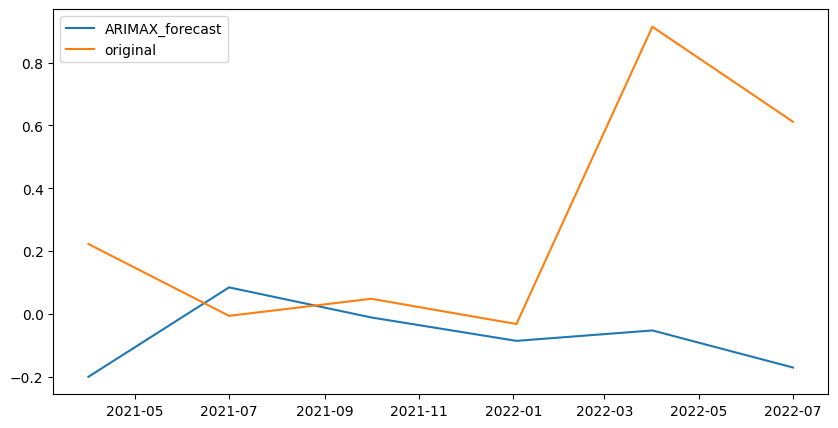

The root mean squared errors are of 1.7390715987973888
_________________________________________________________________________________________________


In [12]:
####################################################### FORECASTS PLOT & RMSE ###################################################################
plt.figure(figsize=(10,5))

# Plot
plt.plot(arimax_forecast, label = 'ARIMAX_forecast')
plt.plot(df_test.returns, label = 'original')
plt.legend()
plt.show()

#RMSE
RMSE = np.sum(np.power(arimax_forecast-df_test.returns,2))
print(f"The root mean squared errors are of {RMSE}")
print("_________________________________________________________________________________________________")

In [13]:
####################################################### MODEL WITH ARDL ###################################################################
result = []
for i in range(5):
    try:
        ardl_model = ARDL(df_train["returns"],i,trend='n', exog=df_exogenous_returns_train).fit()
        result.append([i, ardl_model.aic, ardl_model.bic])
    except Exception as exception:
        pass
result = pd.DataFrame(result,columns=['lags',"AIC","BIC"])
print(result)

print("The analysis of the AIC and BIC components shows that the best model to use would be the ARDL(2) without any trend")
print("We pay more attention to the AIC since we have a small number of observations")
print("___________________________________________________________________________________________________")

   lags       AIC        BIC
0     0  5.825801  23.667697
1     1  8.117587  27.490788
2     2 -1.857944  18.994091
3     3  0.475344  22.751781
4     4  1.501780  25.146093
The analysis of the AIC and BIC components shows that the best model to use would be the ARDL(2) without any trend
We pay more attention to the AIC since we have a small number of observations
___________________________________________________________________________________________________


In [14]:
####################################################### CHOSEN MODEL SUMMARY ###################################################################
ardl_model = ARDL(df_train["returns"],2,trend='n', exog=df_exogenous_returns_train).fit()
ardl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ARDL Model Results                                      
==============================================================================================
Dep. Variable:                                returns   No. Observations:                   44
Model:             ARDL(2, 0, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood                  12.929
Method:                               Conditional MLE   S.D. of innovations              0.178
Date:                                Thu, 29 Dec 2022   AIC                             -1.858
Time:                                        21:06:35   BIC                             18.994
Sample:                                    10-01-2010   HQIC                             5.785
                                         - 01-01-2021                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
returns.L1                                   -0.1170      0.144     -0.811      0.424      -0.411       0.177
returns.L2                                   -0.0893      0.144     -0.621      0.539      -0.383       0.204
Unemployment_fr_returns.L0                   -0.5744      0.843     -0.681      0.501      -2.294       1.146
US_CPI_index_returns.L0                       0.3181      0.133      2.384      0.023       0.046       0.590
FR_CPI_index_returns.L0                      -0.1112      0.089     -1.246      0.222      -0.293       0.071
Stock_EDF_returns.L0                          0.3744      0.156      2.401      0.023       0.056       0.692
EURUSD_Currency_returns.L0                   -1.3793      0.984     -1.401      0.171      -3.387       0.628
Brent_price_returns.L0                       -0.0964      0.241     -0.401      0.692      -0.587       0.395
ECB_refinancing_rate_returns.L0               0.1049      0.103      1.018      0.316      -0.105       0.315
MSCI_World_Energy_Sector_Index_returns.L0     0.3056      0.413      0.741      0.465      -0.536       1.147
CAC_40_returns.L0                            -0.8539      0.340     -2.509      0.018      -1.548      -0.160
=============================================================================================================
"""

In [15]:
####################################################### FORECASTS ###################################################################
ardl_forecast = ardl_model.forecast(steps=6, exog=df_exogenous_returns_test)
ardl_forecast


2021-04-01   -0.155087
2021-07-01    0.056759
2021-10-01   -0.027473
2022-01-03   -0.164606
2022-04-01   -0.058297
2022-07-01   -0.213587
Freq: BQS-OCT, dtype: float64

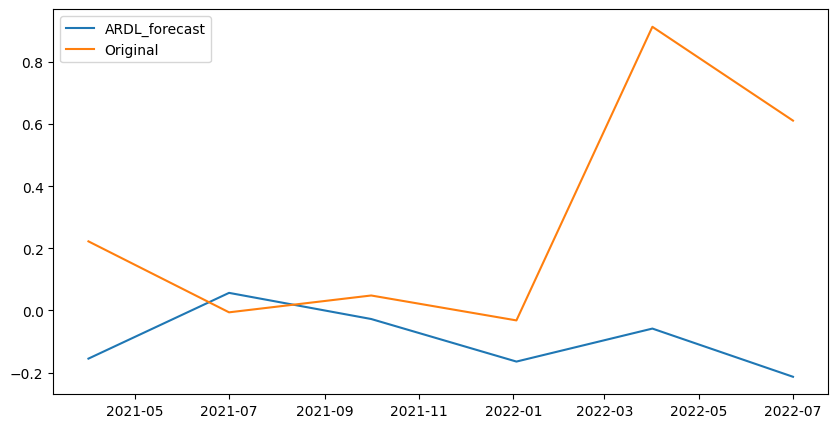

The root mean squared errors are of 1.7966257211326662
_________________________________________________________________________________________________


In [16]:
####################################################### FORECASTS PLOT & RMSE ###################################################################
plt.figure(figsize=(10,5))

# Plot
plt.plot(ardl_forecast, label = 'ARDL_forecast')
plt.plot(df_test.returns, label = 'Original')
plt.legend()
plt.show()

#RMSE
RMSE = np.sum(np.power(ardl_forecast-df_test.returns,2))
print(f"The root mean squared errors are of {RMSE}")
print("_________________________________________________________________________________________________")



***
Conclusion: After analysing the results and the graphs for each model, we can say that the ARIMAX model is better in terms of RMSE values. This is confirmed when we compare the log likelihood of the models: 7 for ARIMAX and 13 ARDL.
***

Improvements can be made since we have a lower AIC value for the ARDL compared to the ARIMAX. So maybe if we were to improve our exogenous data, we may obtain better forecasts using the ARDL model.
